# Helmholtz 1D - Bootstrap on a Fixed Domain Size

## Goal
Given the Helhmholtz operator $A = -\Delta + k^2 I$, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, on a periodic domain, with constant $k$.

To this end, we generate test functions that approximately solve $A x = \lambda x$, where $\lambda$ is the minimum eigenvalue.

## Discretization
We use the 3-point finite difference $A^h = [1, -2 + (kh)^2, 1]$. In this experiment we use a fixed periodic domain with $n=16$ points and a small $kh=0.5$. The final grid on the large domain will have a much smaller $kh$ to yield a good discretization, but as we coarsen it $kh$ increases, so this simulates the level where we already see waves (2 coarse variables per aggregate).

In [7]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from numpy.linalg import eig, norm

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=False)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1-Level

### Exact Eigenpairs
There are 3 positive eigenvalues, corresponding to the constant, left wave and right wave. $\lambda_1$ happens to be a double eigenvalue. We will be attempting to find it and its corresponding eigenvectors $v_1, v_2$ (or combinations of them). 

In [8]:
def exact_eigenpair(a):
    """Returns the exact eigenpairs (v, lam) ((v[:, i], lam[i]) is the ith pair), sorted by
    ascending|lam| value."""
    lam, v = eig(a.toarray())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    return v[:, ind], lam

In [9]:
n = 16
kh = 0.5
a = hm.linalg.helmholtz_1d_operator(kh, n)
print("A in some window")
print(a.toarray()[:5,:5])

A in some window
[[-1.75  1.    0.    0.    0.  ]
 [ 1.   -1.75  1.    0.    0.  ]
 [ 0.    1.   -1.75  1.    0.  ]
 [ 0.    0.    1.   -1.75  1.  ]
 [ 0.    0.    0.    1.   -1.75]]


In [10]:
v, lam = exact_eigenpair(a)
pd.DataFrame(lam)

,0
0,0.097759
1,0.097759
2,0.250000
3,-0.335786
4,-0.335786
5,-0.984633
6,-0.984633
7,-1.750000
8,-1.750000
9,-2.515367


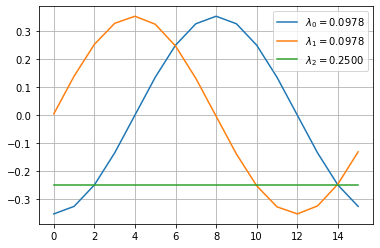

In [11]:
for i in range(3):
    plt.plot(v[:, i], label="$\lambda_{} = {:.4f}$".format(i, lam[i]))
plt.legend();
plt.grid(True);

## 1-Level Method
To generate $K$ examples (i.e., a test matrix $x_{n \times K}$), the 1-level method is the iteration
* $\nu$ Kaczmarz relaxation sweeps on $A x - \lambda x = 0$ with fixed $\lambda$.
* Update $x \longleftarrow x_k / (x_k^T x_k)^{\frac12}$ for all $k$, $\lambda \longleftarrow mean_k((x_k^T A x_k)/(x_k^T x_k))$, where $x_k$ is the $k$th column of $x$.

### Asymptotic Convergence
We start from $x \longleftarrow rand[-1,1], \lambda \longleftarrow 0$ and perform 1-level iterations.

In [12]:
n = 16
kh = 0.5
a = hm.linalg.helmholtz_1d_operator(kh, n)
level =helmholtz.setup.multilevel.Level.create_finest_level(a)
multilevel =helmholtz.setup.multilevel.Multilevel()
multilevel.level.append(level)

TypeError: __init__() missing 1 required positional argument: 'finest_level'

In [ ]:
# Run enough Kaczmarz relaxations per lambda update (not just 1 relaxation) so we converge to the minimal one.
num_iters = 10

logger = logging.getLogger("multilevel")
logger.setLevel(logging.DEBUG)

for nu in (1, 5, 10, 100):
    x =helmholtz.setup.multilevel.random_test_matrix((n,), num_examples=10)
    level.global_params.lam = 0
    print("nu {}".format(nu))
    method = lambda x: multilevel.relax_cycle(x, None, None, 1, relax_coarsest=nu)
    x, conv_factor =helmholtz.setup.multilevel.relax_test_matrix(level.operator, level.rq, method, x, num_iters, print_frequency=1)

It turns out that $\nu$ must be sufficiently large ($100$) to guarantee convergence to the smallest eigenvalue, and even then it depends on the initial guess. This is perhaps because Kaczmarz is a slow relaxation, but more likely because a random initial guess is not good enough. 

Perhaps that's OK; for bootstrapping, we need the initial vectors to be smooth enough, but not necessarily the exact lowest eigenvector.

### Relaxed Test Functions
Now, employ a reasonable number of Kacmzarz sweeps per iteration, and iterations.

In [ ]:
num_sweeps = 10
nu = 5

# Generate relaxed test matrix.
level =helmholtz.setup.multilevel.Level.create_finest_level(a)
x =helmholtz.setup.multilevel.random_test_matrix((n,))
b = np.zeros_like(x)
method = lambda x: multilevel.relax_cycle(x, None, None, 1, relax_coarsest=nu)
x, _ =helmholtz.setup.multilevel.relax_test_matrix(level.operator, level.rq, method, x, num_sweeps=num_sweeps)

In [ ]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 1-level iterations with $\\nu={}$".format(num_iters, nu));
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

In [ ]:
print("Theoretical #points per period {:.2f}".format(2*np.pi/kh))

## Coarsening

### Restriction: SVD on Window (Aggregate)
Let $w=4$ be the size of the window. We find $K = 4 w$ relaxed vectors and calculate the SVD of $x[w,:]$. The rows of the restriction $R$ are the principal components that guarantee $10\%$ reconstruction error. 

In [ ]:
# Generate coarse variables (R) based on a window of x.
aggregate_size = 4
x_aggregate_t = x[:aggregate_size].transpose()
r, s = hm.restriction.create_restriction(x_aggregate_t, 0.1)

In [ ]:
r.asarray()

In [ ]:
print("Singular values {}".format(s))
print("%unexplained energy / interpolation error {:.3f}".format(
    (sum(s[2:]**2)/sum(s**2))**0.5))

In [ ]:
colors = ["b", "r"]
rr = r.asarray()
for i, color in enumerate(colors):
    plt.plot(np.arange(1, aggregate_size + 1), rr[i], '{}o-'.format(color[i  % len(color)]), label="$\sigma_{" + str(i+1) + "} = " + "{:.2f}".format(s[i]) + "$")
plt.ylim([-0.7, 0.7]);
plt.legend(loc="upper right");
plt.grid(True);
plt.title("Coarse Vars / Basis Functions on Aggregate");

<!-- ### Identifying Neighborhoods Algebraically -->

In [ ]:
# print("Test Matrix dimension: ", x.shape)

In [ ]:
# xt = x.transpose()
# d = sklearn.metrics.pairwise.cosine_similarity(x, x)
# print("(x, x) cos similarity")
# print(d)

For this small $kh$ value, we see that the nearest neighbors are indeed gometric neighbors.

## 2-Level Convergence
Define a bootstrap cycle:
* Relax at the finest level (or perform iterations with the current cycle) on $A x = \lambda  B x$ with $B = I$.
* Construct coarse level: $R$ by SVD and tiling over the entire domain; $P = R^T$; $A^c = R A P$; $B^c = R B P$.

We run two bootstrap cycles.

This gives us a multilevel hierarchy, for which we define an FAS cycle for $A x = \lambda x$. We define $\sigma^0 \equiv 1$ (a vector of size $K$) and $\eta^l(x^l) = (x^l)^T B x^l$.
. At level $l$, it consists of the steps
* If $l = N_{levels}-1$ (coarsest),
  * Repeat $30$ times:
    * Run $5$ Kaczmarz relaxation sweeps on $A x^l - \lambda x^l = b^l$ with fixed $\lambda$.
    * Update $x \longleftarrow x^l_k (\sigma^l_k / \eta^l(x^l))^{\frac12}$ for all $k$, $\lambda \longleftarrow mean_k(((x^l_k)^T (A^l x^l_k - b^l_k))/((x^l_k)^T B^l x^l_k))$, where $x^l_k$ is the $k$th column of $x^l$.
* Else:
  * Relax $\nu_1$ times $A x^l - \lambda B x^l = b^l$.
  * Set $x^{l+1} \longleftarrow R^{l+1} x^l$. Save $x^{l+1}_{INIT} \longleftarrow x^{l+1}$.
  * Set $b^{l+1} \longleftarrow R^{l+1} (b^l - A^l x^l) + A^{l+1} x^{l+1}$.
  * Set $\sigma^{l+1} \longleftarrow \sigma^l - \eta^l(x^l) + \eta^{l+1} x^{l+1}$.
  * Perform $\gamma$ cycles at level $l+1$.
  * Correct $x^l \longleftarrow x^l + P(x^{l+1} - x^{l+1}_{INIT})$.
  * Relax $\nu_2$ times $A x^l - \lambda B x^l = b^l$.
  
Note how we keep a single $\lambda$ value for all test functions and update it to the mean Rayleigh quotient at the coarsest level.

### Example where things go well

In [ ]:
np.random.seed(0)
x, multilevel = helmholtz.repetitive.bootstrap_repetitive.generate_test_matrix(a, 0, num_examples=8, num_bootstrap_steps=2)
assert len(multilevel) == 2

# FMG start so (x, lambda) has a reasonable initial guess.
level = multilevel.level[0]
x_init = helmholtz.repetitive.bootstrap_repetitive.fmg(multilevel, num_cycles_finest=0)

# Check that (3,3) is at least as fast as (3,2). Print conv factor vs. nu1, nu2.
# x, lam = exact_eigenpair(multilevel.level[0].a)
# x = x[:, None]
# multilevel.level[0].global_params.lam = lam

In [ ]:
print("R on aggregate")
print(multilevel.level[1].r.asarray())
print("A^c")
print(multilevel.level[1].a.toarray())

In [ ]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 2-level bootstrap");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

### Stationarity Test
Starting from exact solution, the cycle doesn't change the residuals, whether the relaxations are applied before or after the coarse-level correction during the cycle.

In [ ]:
# Stationarity test of Cycle(0, 2).
x = v[:, :1]
multilevel.level[0].global_params.lam = lam[0]
multilevel.relax_cycle(x, 0, 2, 30, update_lam="coarsest", debug=True);

# Stationarity test of Cycle(2, 0).
x = v[:, :1]
multilevel.level[0].global_params.lam = lam[0]
multilevel.relax_cycle(x, 2, 0, 30, update_lam="coarsest", debug=True);

### Asymptotic Convergence vs. $\nu_1 + \nu_2$
We test both $Cycle(0,\nu)$ and $Cycle(\nu,0)$ for $\nu=1,\dots,8$. We expect that
* The asymptotic convergence of both cycles is the same.
* The convergence improves with $\nu$, up to a point (bounded by the interpolation/coarse-level correction accuracy).

In [ ]:
logger = logging.getLogger("multilevel")
logger.setLevel(logging.INFO)

def two_level_conv_factor(nu1, nu2):
    logger.debug("nu1 {} nu2 {}".format(nu1, nu2))
    relax_cycle = lambda x: multilevel.relax_cycle(x, nu1, nu2, 10, update_lam="coarsest")
    x = x_init.copy()
    x, conv_factor =helmholtz.setup.multilevel.relax_test_matrix(
        level.operator, level.rq, relax_cycle, x, 10,
        residual_stop_value=1e-11, lam_stop_value=1e-20)
    return conv_factor


conv_factor = pd.DataFrame([
    [two_level_conv_factor(nu1, nu2) for nu2 in range(6)]
    for nu1 in range(6)])

Two-level convergence factor (measured over the last 5 cycles) vs. $\nu_1$ (down), $\nu_2$ (across):

In [ ]:
conv_factor

The convergence factor depends only on $\nu_1+\nu_2$ and improves with $\nu_1+\nu_2$, up to $0.2$. For an interpolation error of $\varepsilon$, if a fine-operator eigenvector's eigenvalue is $\lambda$ and the corresponding coarse-operator eigenvalue os $lam^c$, we can expect a coarse-level correction error $\approx 1 - (1-\varepsilon)^2 (\lambda^c/\lambda)$. The experimental result is close to this rule-of-thumb estimation.

In [ ]:
lam1 = eig(multilevel.level[1].a.toarray())[0]
lam1 = lam1[np.argsort(np.abs(lam1))]
print("Fine lam (smallest 8)", lam[:8])
print("Coarse lam           ", lam1)
print("Ratio                ", lam1 / lam[:8])

In [ ]:
print("Rule of thumb lower bound for coarse level operator's convergence of smooth components {:.2f}".format(1 - (1 - 0.095)**2 * 1.03))

### Case of Random Start that Leads to Bad Multilevel Hierarchy
Problem: the quality of the multilevel hierarchy (2-level convergence factors) depends on the random start of the bootstrap process. Here's an example where things go badly.

In [ ]:
np.random.seed(1)
x, multilevel = helmholtz.repetitive.bootstrap_repetitive.generate_test_matrix(a, 0, num_examples=8, num_bootstrap_steps=2)
assert len(multilevel) == 2

# FMG start so (x, lambda) has a reasonable initial guess.
level = multilevel.level[0]
x_init = helmholtz.repetitive.bootstrap_repetitive.fmg(multilevel, num_cycles_finest=0)

# Check that (3,3) is at least as fast as (3,2). Print conv factor vs. nu1, nu2.
# x, lam = exact_eigenpair(multilevel.level[0].a)
# x = x[:, None]
# multilevel.level[0].global_params.lam = lam

In [ ]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 2-level bootstrap");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

In [ ]:
conv_factor = pd.DataFrame([
    [two_level_conv_factor(nu1, nu2) for nu2 in range(6)]
    for nu1 in range(6)])
conv_factor

In [ ]:
print("R on aggregate")
print(multilevel.level[1].r.asarray())
print("A^c")
print(multilevel.level[1].a.toarray())

In [ ]:
logger = logging.getLogger("multilevel")
logger.setLevel(logging.DEBUG)

nu1 = 0
nu2 = 4
logger.debug("nu1 {} nu2 {}".format(nu1, nu2))
relax_cycle = lambda x: multilevel.relax_cycle(x, nu1, nu2, 10, update_lam="coarsest")
x = x_init.copy()
x, conv_factor =helmholtz.setup.multilevel.relax_test_matrix(
    level.operator, level.rq, relax_cycle, x, 20,
    residual_stop_value=1e-11, lam_stop_value=1e-20)
print("Asymptotic Convergence Factor {:.2f}".format(conv_factor))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

ax = axs[0]
ax.plot(x[:, 0])
ax.set_title("Asymptotic $x$ in $Cycle({},{})$".format(nu1, nu2));
ax.grid(True);

ax = axs[1]
ax.plot(x[:, 0] - v[:, 0])
ax.set_title("Asymptotic $e = x - v_0$ in $Cycle({},{})$".format(nu1, nu2));
ax.grid(True);

Looks like the convergence factor was estimated on too few cycles; with more, we see convergence, but not the smallest $\lambda$, and it takes many cycles to find the right nonlinear solution. This must be an initial guess issue.
* The coarse operator and $R$ don't seem much different than the "good" run.
* Probably because the test functions are not smooth enough.
* Note that the asymptotic $x$ contains a large constant component here.

How can we improve the initial guess to the bootstrap process to avoid this?

## 3-Level Convergence

Generally, the bootstrap cycle is defined by
* Run $10$ iterations of. One-level method (or perform iterations with the current $Cycle(2, 2)$) $10$ times at the finest level $l=0$ on $A x = \lambda x$ to obtain $x^0$.
* For $l = 1,\dots,N_{levels}$, 
  * Construct coarse level $l$: $R$ by SVD and tiling over the entire domain; $P = R^T$; $A^c = R A P$.
  * $x^l \longleftarrow R x^{l-1}$.
  * Relax on $A^l x = \lambda^l x$ to improve $x^l$.
  
We perfom two bootstrap cycles, starting from $x = rand[-1,1]$ and $\lambda=0$.

In [ ]:
np.random.seed(4)
x, multilevel = helmholtz.repetitive.bootstrap_repetitive.generate_test_matrix(a, 0, num_sweeps=10, num_examples=20, num_bootstrap_steps=1,
                                                  initial_max_levels=3)
assert len(multilevel) == 3

level = multilevel.level[0]

In [ ]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 2-level bootstrap");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

### V(2,2) Convergence Speed Test
We start cycling from an FMG start so $(x, \lambda)$ has a reasonable initial guess.

In [ ]:
# Convergence speed test.
# FMG start so (x, lambda) has a reasonable initial guess.
x_init = helmholtz.repetitive.bootstrap_repetitive.fmg(multilevel, num_cycles_finest=0, num_cycles=1)

relax_cycle = lambda x: multilevel.relax_cycle(x, 2, 2, 100, max_levels=3)
x, conv_factor =helmholtz.setup.multilevel.relax_test_matrix(level.operator, level.rq, relax_cycle, x_init, 15)
print("Asymptotic Convergence Factor {:.2f}".format(conv_factor))

The asymptotic convergence factor isn't bad, and is close to the two-level factor. But again, notice how during the bootstrap run, the obtained $\lambda$ value is not the smallest in absolute value of $A$.